In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rcpl.config import BASE_DIR, FIGURES_DIR, MPL_RC, DATA_DIR
from rcpl.config import CONFIGS_DIR
from rcpl.prediction import ChainPredictor

mpl.rcParams.update(MPL_RC)
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [25]:
DEVICE = 'cuda'
D1 = 'exp2023-11-23.maftr2_4.template'
D2 = 'maftr2_4.template'

In [5]:
exp_path, e_id = DATA_DIR / 'epsp_stress/measured/2023-11-23.json', 1
# exp_path, e_id = DATA_DIR / 'epsp_stress/measured/2023-11-07.json', 2

In [7]:
gru_predictor = ChainPredictor(config_path=CONFIGS_DIR / 'maftr/maftr2_4.best/gru.yaml', predicts_scaled_theta=True)
ttopt_predictor = ChainPredictor(config_path=CONFIGS_DIR / 'maftr/maftr2_4.best/ttopt.yaml', predicts_scaled_theta=False)

In [12]:
unscaled_theta_opt_gru, stress_pred_opt_gru, (new_score_gru, old_score_gru) = gru_predictor.predict_from_json_simplex(exp_path)

Origin score: 2968.52, Nelder-Mead score: 634.58


(634.5804350291795, 2968.523359150013)

In [10]:
unscaled_theta_opt_ttopt, stress_pred_opt_ttopt, (new_score_ttopt, old_score_ttopt) = ttopt_predictor.predict_from_json_simplex(exp_path)

Origin score: 694.50, Nelder-Mead score: 626.06


(626.06312516845, 694.4952485676745)

In [16]:
best_theta = None
best_score = np.inf
SAVE_PATH = BASE_DIR / 'local_data/histograms' /f'{exp_path.stem}.scores.npz'
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
if SAVE_PATH.exists():
    data = np.load(BASE_DIR / 'local_data/histograms' /f'{exp_path.stem}.scores.npz')
    all_n_scores = data['all_n_scores'].tolist()
    all_o_scores = data['all_o_scores'].tolist()
else:
    all_n_scores = []
    all_o_scores = []

In [22]:
model_factory = gru_predictor.chain.model_factory.value
for i in tqdm(range(len(all_n_scores), 250000), initial=len(all_n_scores)):
    try:
        if len(all_n_scores) % 1000 == 0:
            np.savez(BASE_DIR / 'local_data/histograms' /f'{exp_path.stem}.scores.npz', all_n_scores=all_n_scores, all_o_scores=all_o_scores)
        rand_theta = model_factory.make_random_theta()
        _,_,(n_score_i, o_score_i) = gru_predictor.run_simplex_on_exp(exp_path, rand_theta)
        all_n_scores.append(n_score_i)
        all_o_scores.append(o_score_i)
        if n_score_i < best_score:
            best_score = n_score_i
            best_theta = rand_theta
            print(best_score)
        
    except KeyboardInterrupt:
        break

252083it [4:04:55,  3.75it/s]


In [ ]:
data = [i for i in all_n_scores[:250000] if i < 1500]
weights = [1 / len(all_n_scores[:250000])] * len(data)

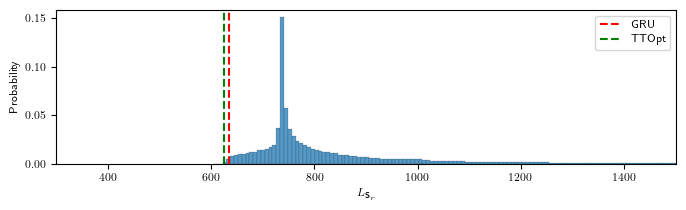

In [24]:
plt.figure(figsize=(8, 2))
plt.hist(data, bins=120, weights=weights, edgecolor='black', linewidth=0.1, color='#5699c6')
plt.axvline(x=new_score_gru, color='r', linestyle='--', label='GRU')
plt.axvline(x=new_score_ttopt, color='g', linestyle='--', label='TTOpt')
plt.xlim([300, 1500])
plt.xlabel(r'$L_{\textbf{S}_r}$')
plt.legend()
plt.ylabel('Probability')
plt.savefig(FIGURES_DIR / f'{exp_path.stem}_random.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

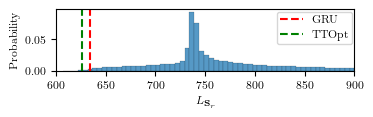

In [27]:
plt.hist(data, bins=60, weights=weights, edgecolor='black', linewidth=0.1, color='#5699c6')
plt.axvline(x=new_score_gru, color='r', linestyle='--', label='GRU')
plt.axvline(x=new_score_ttopt, color='g', linestyle='--', label='TTOpt')
plt.xlim([600, 900])
plt.xlabel(r'$L_{\textbf{S}_r}$')
plt.legend(frameon=True, labelspacing=0.5, handlelength=2, fontsize=8, borderpad=0.3, columnspacing=1, borderaxespad=0.2)
plt.ylabel('Probability')
plt.savefig(FIGURES_DIR / f'{exp_path.stem}_random_small.pdf', bbox_inches='tight', pad_inches=0)
plt.show()